# Image Classification

Dataset is CIFAR-10 from torchvision. That's colored images including 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' ten classes. Each image is $3*32*32$

There 5 steps:
1. Using torchvision to loading and preprocessing CIFAR-10 dataset
2. Define network
3. Define loss function and optimizer
4. Train network and update network parameters
5. Test network

In [1]:
import os

import torch as t
import torchvision as tv
from torchvision import transforms
from torchvision.transforms import ToPILImage
to_pil = ToPILImage()

In [2]:
# os.getcwd()
# print(t.__version__)
# ! pip install torch torchvision -U

## Load and preprocess data

In [3]:
# Define data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# train set
trainset = tv.datasets.CIFAR10(
    root = './data/',
    train = True,
    download = True,
    transform = transform
)

# DataLoader returns a iterable object, each unit is based on the batch size, 
# and multithreads and shuffle are supported. 
trainloader = t.utils.data.DataLoader(
    trainset,
    batch_size = 4,
    shuffle = True,
    num_workers = 4
)

# test set
testset = tv.datasets.CIFAR10(
    root = './data/',
    train = False,
    download = True,
    transform = transform
)

testloader = t.utils.data.DataLoader(
    testset,
    batch_size = 4,
    shuffle = True,
    num_workers = 4
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

car


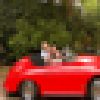

In [5]:
data, lable = trainset[99]
print(classes[lable])

# (data+1)/2 to restore normalized picture
to_pil((data+1)/2).resize((100, 100))

horse	   car	   frog	   bird


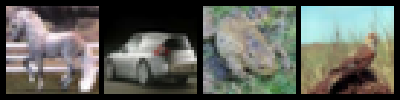

In [6]:
dataiter = iter(trainloader)
images, lables = dataiter.next()
print('\t   '.join([classes[lables[i]] for i in range(4)]))   # batch size is 4
to_pil(tv.utils.make_grid((images+1)/2)).resize((400, 100))

## Define networks

In [11]:
from torch import nn 
from torch.nn import functional as Func
from torch import optim

In [19]:
class Net(nn.Module):

    def __init__(self):
        """
        There two things should we notice:
        1. The subclass of nn.Module must execute the construct function of 
           superclass in construct function.
        2. torch.nn only support mini-batches, so we can't input one sample for one time,
           like for nn.Conv2d in this net, the input must be 4-dimensional, like
           nSamples * nChannels * Hight * width.
           Of course, we can use input.unsqueeze(0) to set batch size to 1.
        """
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        """
        once forward function is defined in subclass of nn.Module, 
        backward function will be implemented automatically by autograd
        """
        
        # convolution -> activation -> pooling
        x = Func.max_pool2d(Func.relu(self.conv1(x)), (2, 2))
        x = Func.max_pool2d(Func.relu(self.conv2(x)), 2)
        x = x.view(x.size()[0], -1)    # reshape, -1 means self-adaption（自适应）
        x = Func.relu(self.fc1(x))
        x = Func.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [20]:
for name,parameters in net.named_parameters():
    print(name,':',parameters.size())

conv1.weight : torch.Size([6, 3, 5, 5])
conv1.bias : torch.Size([6])
conv2.weight : torch.Size([16, 6, 5, 5])
conv2.bias : torch.Size([16])
fc1.weight : torch.Size([120, 400])
fc1.bias : torch.Size([120])
fc2.weight : torch.Size([84, 120])
fc2.bias : torch.Size([84])
fc3.weight : torch.Size([10, 84])
fc3.bias : torch.Size([10])


## Define loss function and optimizer

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Network training

All kinds of networks training are similar.  
Proceed following steps repeatly.
* Input data 
* forward & backward 
* update parameters

In [22]:
t.set_num_threads(8)
for epoch in range(2):
    run_loss =0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        # 1. reset optimizer's gradiant
        optimizer.zero_grad()    # same as net.zero_grad()
        
        # 2. forward + backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()   # update gradiant
        
        # 3. update parameters
        optimizer.step()
        
        # print loss info
        # loss is scalar, so we should use loss.item() to get its value, but not loss[0]
        run_loss += loss.item()
        if i%2000 == 1999:    # each 2000 batches, print training statement
            print(f'[{epoch+1}, {i+1}] loss: {run_loss/2000}')   # average loss of 2000 batches
            run_loss = 0.0
            
print('Training finished.')

[1, 2000] loss: 2.123044124662876
[1, 4000] loss: 1.8038696492612363
[1, 6000] loss: 1.6612129672467708
[1, 8000] loss: 1.5795892687141895
[1, 10000] loss: 1.5386991807222365
[1, 12000] loss: 1.4893240099996328
[2, 2000] loss: 1.415684333741665
[2, 4000] loss: 1.3782200061678886
[2, 6000] loss: 1.3667132899165153
[2, 8000] loss: 1.3156589175760747
[2, 10000] loss: 1.3157717502713204
[2, 12000] loss: 1.2883637679964304
Training finished.


## Test network

horse	   car	   frog	   bird


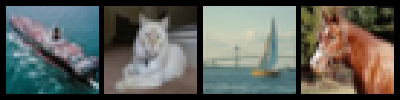

In [24]:
dataiter = iter(testloader)
images, labels = dataiter.next()
print('\t   '.join([classes[lables[i]] for i in range(4)]))
to_pil(tv.utils.make_grid((images+1)/2)).resize((400, 100))

In [27]:
outputs = net(images)   # calculate each image's score on each class
print(outputs.size())
_, predicts = t.max(outputs.data, 1)  # apply the class with highest score
s = '\t'.join([classes[predicts[i]] for i in range(4)])
print(f"Predict: {s}")

torch.Size([4, 10])
Predict: plane	dog	bird	horse
tensor([[ 2.6792, -2.8278,  2.3237, -0.2902,  1.1985, -1.1576, -1.9321, -0.5394,
          2.1376, -0.6986],
        [-2.0768, -3.2867,  0.4575,  3.5394, -0.7521,  4.2574, -0.4095,  0.3753,
         -1.2325, -2.4568],
        [ 1.1144, -2.5009,  2.3113,  0.6499,  0.2988, -0.3057, -0.2399, -1.5053,
          1.3938, -1.3418],
        [-1.8068, -0.6194,  0.1362,  0.9249,  0.9755,  1.3911,  1.2056,  1.6934,
         -2.6112, -0.1531]], grad_fn=<AddmmBackward>)


In [28]:
correct, total = 0, 0

# There is no need to make gradiant when testing, 
# so we could close autograd to increase the speed and save memory
with t.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicts = t.max(outputs.data, 1)
        total += labels.size()[0]
        correct += (predicts == labels).sum()

print(f'Precision of 10000 images: {100 * correct / total}%')

Precision of 10000 images: 54%


## Train network on GPU

In [31]:
s = 'cuda:0' if t.cuda.is_available() else 'cpu'
print(s)

cpu


In [29]:
# Because it's ran on my mac, so gpu is not supported, it'll work on Google Colab
device = t.device(s)

net.to(device)
images = images.to(device)
labels = lables.to(device)
output = net(images)
loss= criterion(output,labels)

loss